# Cartpole Challenge

In [1]:
import gym
import random
import numpy as np
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter
import tensorflow as tf
from functools import reduce


import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
env.reset()

C:\Users\Blup\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.00246717,  0.03947352, -0.03847333,  0.04343706])

# Create random training Data
Create random training data and keep above avarage performing examples.

In [2]:
def create_random_training_data(n_games=100, percentile_threshold=75):
    games = []
    for iteration in range(n_games):
        if(iteration % 10000 == 0):
            print('Random data generation iteration ' + str(iteration) + '/' + str(n_games))
        
        score = 0
        game_data = []
        prev_observation = env.reset()
        while True:
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            action_one_hot = [0,1] if (action == 1) else [1,0]
            game_data.append([prev_observation, action_one_hot])
            
            prev_observation = observation
            
            deviation_from_center = np.absolute(observation[0])
            score += reward - deviation_from_center
            
            if done:
                break
        games.append([score, game_data])
        
        
    #training_data_save = np.array(training_data)
    #np.save('saved.npy', training_data_save)

    scores = list(map(lambda game: game[0], games))
    score_threshold = np.percentile( scores , percentile_threshold)

    games = list(filter( (lambda game: game[0]>=score_threshold), games))
    training_data_by_game = list(map( (lambda game: game[1]), games))
    flat_training_data = reduce(lambda x,y: x+y, training_data_by_game)
    
    plt.hist(scores, bins=30)
    plt.title('Scores for random training data')
    plt.axvline(x=score_threshold, color='r')
    plt.text(score_threshold,-1,'threshold',rotation=90)

    
    return flat_training_data


Executing this should result in a decent training set.

Random data generation iteration 0/100


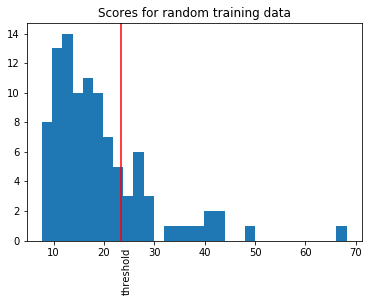

In [3]:
random_training_data = create_random_training_data(n_games=100, percentile_threshold=75)

# Create the model

In [4]:
def create_model(learning_rate=1e-3):
    print("Creating model")
    
    input_size = 4
    network = input_data(shape = [None, input_size, 1], name='input')
    
    network = fully_connected(network, 16, activation='relu')
    #network = dropout(network, 0.8)

    network = fully_connected(network, 16, activation='relu')
    #network = dropout(network, 0.8)


    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=learning_rate, 
                    loss = 'categorical_crossentropy', name='targets')

    model = tflearn.DNN(network, tensorboard_dir='log')
    return model

In [5]:
def train_model(training_data, model=False):
    print("Reshaping array")
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]), 1)
    Y = [i[1] for i in training_data]

    if not model:
        model = create_model()
    
    print("Training model")
    model.fit({'input':X}, {'targets':Y}, n_epoch=5, snapshot_step=500, show_metric=True,
                run_id='openaistuff')

    return model

Training Step: 7559  | total loss: 0.66288 | time: 19.292s
| Adam | epoch: 005 | loss: 0.66288 - acc: 0.5770 -- iter: 96704/96752
Training Step: 7560  | total loss: 0.66040 | time: 19.301s
| Adam | epoch: 005 | loss: 0.66040 - acc: 0.5880 -- iter: 96752/96752
--


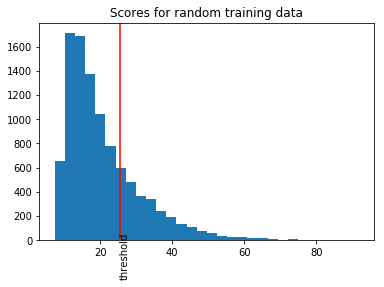

In [6]:
random_training_data = create_random_training_data(n_games=10000, percentile_threshold=75)
model = train_model(random_training_data)